In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates


# Step 0: Load the Sentiment data & Merge with the Returnson the date of the publication for the companies in the Dow30

In [38]:
def load_and_merge_sentiment_data(file1, file2):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    sentiment_dow = pd.concat([df1, df2], ignore_index=True)
    sentiment_dow.drop_duplicates(inplace=True)
    sentiment_dow.to_csv("sentiment_dow.csv", index=False)
    
    print("Merging complete! File saved as 'sentiment_dow.csv'.")
    return sentiment_dow

def load_stock_returns(file):
    df = pd.read_csv(file)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['PERMNO'] = df['PERMNO'].astype(int)
    return df
    
def load_factor_data(file):
    df_factor = pd.read_csv(file, encoding='utf-8')
    df_factor['date'] = pd.to_datetime(df_factor['date'])
    return df_factor

def merge_sentiment_with_returns(sentiment_df, stock_returns_df):
    sentiment_df['release_date'] = pd.to_datetime(sentiment_df['release_date'], errors='coerce')
    sentiment_df['permno'] = sentiment_df['permno'].astype(int)

    merged_df = stock_returns_df.merge(
        sentiment_df[['permno', 'release_date', 'sentiment_score']],
        left_on=['PERMNO', 'date'],
        right_on=['permno', 'release_date'],
        how='inner'
    )

    merged_df.drop(columns=['permno', 'release_date'], errors='ignore', inplace=True)
    merged_df['RET'] = pd.to_numeric(merged_df['RET'], errors='coerce')

    return merged_df

# Step 1: Strategies logic breakdown

## Strategy 1 - LS trade on all sentiment score
- long all positive sentiment scores
- short all negative sentiment score
- logic: simplest sentiment long-short strategy

In [42]:
def define_positions(merged_df):
    """
    Defines long, short, or neutral positions based on sentiment scores.
    """
    merged_df['position'] = merged_df['sentiment_score'].apply(
        lambda x: 1 if x > 0 else -1 if x < 0 else 0
    )

    long_positions = merged_df[merged_df['position'] == 1]
    short_positions = merged_df[merged_df['position'] == -1]
    
    return long_positions, short_positions

def calculate_position_returns(long_positions, short_positions):
    """
    Calculates the returns for long and short positions and combines them into a strategy.
    """
    long_returns = long_positions.groupby(['date'])['RET'].mean()
    short_returns = short_positions.groupby(['date'])['RET'].mean()

    long_returns = pd.to_numeric(long_returns, errors='coerce')
    short_returns = pd.to_numeric(short_returns, errors='coerce')

    strategy = pd.concat([long_returns, short_returns], axis=1).fillna(0)
    strategy.columns = ['long_returns', 'short_returns']

    strategy['LS_return'] = strategy['long_returns'] - strategy['short_returns']
    strategy.reset_index(inplace=True)
    
    return strategy[['date', 'LS_return']]



## Strategy 2 - 10th percentile
- long top 10 percentile of sentiment score
- short bottom 10 percentile of sentiment scores
- logic: execute only the strongest signal trades and ignore the rest


In [46]:
def define_positions_by_percentile(merged_df, lower_percentile=0.10, upper_percentile=0.90):
    lower_bound = merged_df['sentiment_score'].quantile(lower_percentile)
    upper_bound = merged_df['sentiment_score'].quantile(upper_percentile)

    merged_df['position_v2'] = merged_df['sentiment_score'].apply(
        lambda x: 1 if x > upper_bound else (-1 if x < lower_bound else 0)
    )

    long_positions_v2 = merged_df[merged_df['position_v2'] == 1]
    short_positions_v2 = merged_df[merged_df['position_v2'] == -1]

    return long_positions_v2, short_positions_v2

def calculate_position_returns_v2(long_positions_v2, short_positions_v2):
    """
    Calculates the returns for long and short positions based on percentiles and combines them into a strategy.
    """
    long_returns_v2 = long_positions_v2.groupby(['date'])['RET'].mean()
    short_returns_v2 = short_positions_v2.groupby(['date'])['RET'].mean()

    long_returns_v2 = pd.to_numeric(long_returns_v2, errors='coerce')
    short_returns_v2 = pd.to_numeric(short_returns_v2, errors='coerce')

    strategy_v2 = pd.concat([long_returns_v2, short_returns_v2], axis=1).fillna(0)
    strategy_v2.columns = ['long_returns_v2', 'short_returns_v2']

    strategy_v2['LS_return_v2'] = strategy_v2['long_returns_v2'] - strategy_v2['short_returns_v2']
    strategy_v2.reset_index(inplace=True)

    return strategy_v2[['date', 'LS_return_v2']]

# Step 2: Analysis of cumulative returns of the strategies

In [52]:
def analyze_cumulative_returns(strategy_df, column_name='LS_return'):
    """
    Plots the cumulative returns of a trading strategy and displays the annualized Sharpe ratio.

    Parameters:
    - strategy_df: DataFrame containing the strategy returns.
    - column_name: The name of the column containing the strategy returns.
    """
    # Ensure 'date' is the index for proper plotting
    strategy_df = strategy_df.set_index('date')

    # Calculate cumulative returns
    cumulative_returns = strategy_df[column_name].cumsum()
    
    # Compute the Sharpe ratio
    excess_returns = strategy_df[column_name] 
    daily_sharpe_ratio = excess_returns.mean() / excess_returns.std()
    annualized_sharpe_ratio = daily_sharpe_ratio * (252**0.5)
    
    # Plotting the cumulative returns
    plt.figure(figsize=(10, 6))
    #plt.plot(cumulative_returns.index, cumulative_returns.values, label='Cumulative Returns')
    plt.step(cumulative_returns.index, cumulative_returns.values, where='post', label='Cumulative Returns', linewidth=1.5, color='blue')

    # Format the x-axis to show years
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Rotate the x-axis labels for better readability
    plt.gcf().autofmt_xdate()
    
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns Over Time')
    
    # Print the Sharpe Ratio on the graph
    plt.text(0.5, 0.1, f'Sharpe Ratio: {annualized_sharpe_ratio:.2f}', transform=plt.gca().transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.5))

    # Place the legend outside the plot area
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    # Adjust the layout to make room for the legend
    plt.tight_layout()

    # Show the plot
    plt.legend()
    plt.show()

    # Ensure proper merging with factor data
    strategy_df = strategy_df.reset_index()  # Ensure 'date' is a column for merging
    merged_df = pd.merge(df_factor, strategy_df, on='date', how='inner')

    # Define the independent variables (X) and the dependent variable (y)
    merged_df = merged_df.dropna(subset=[column_name]) 
    X = merged_df[['mktrf', 'smb', 'hml', 'umd']]  # Independent variables
    y = merged_df[column_name]  # Dependent variable
    
    # Add a constant to the model (the intercept term)
    X = sm.add_constant(X)
    
    # Create the OLS model and fit it
    model = sm.OLS(y, X).fit()
    
    # Print the summary of the regression
    print(model.summary())





# Step 3: Main executions logic

In [98]:
# Main script to execute the functions
stock_file = "stocks_daily.csv"
factor_file = "FF_factors.csv"

# Sentiment dictionaries
file1 = "result_df_3.csv"
file2 = "result_df_1.csv"

# Sentiment FinBERT
file3 = "df_res.csv"
# Sentiment GPT
file4 = "df_res_chat.csv"

# Load the data
sentiment_dict = load_and_merge_sentiment_data(file1, file2)
sentiment_finbert = pd.read_csv(file3) 
sentiment_gpt = pd.read_csv(file4)

#df_d = load_stock_returns(stock_file)  # Daily data is the same as stock returns
#df_factor = load_factor_data(factor_file)

Merging complete! File saved as 'sentiment_dow.csv'.


## 1. Dictionary-Based Sentiment Strategies: 
- 1.1 Simple Long-Short
- 1.2 Long top 10 percentile, Short bottom 10 percentile

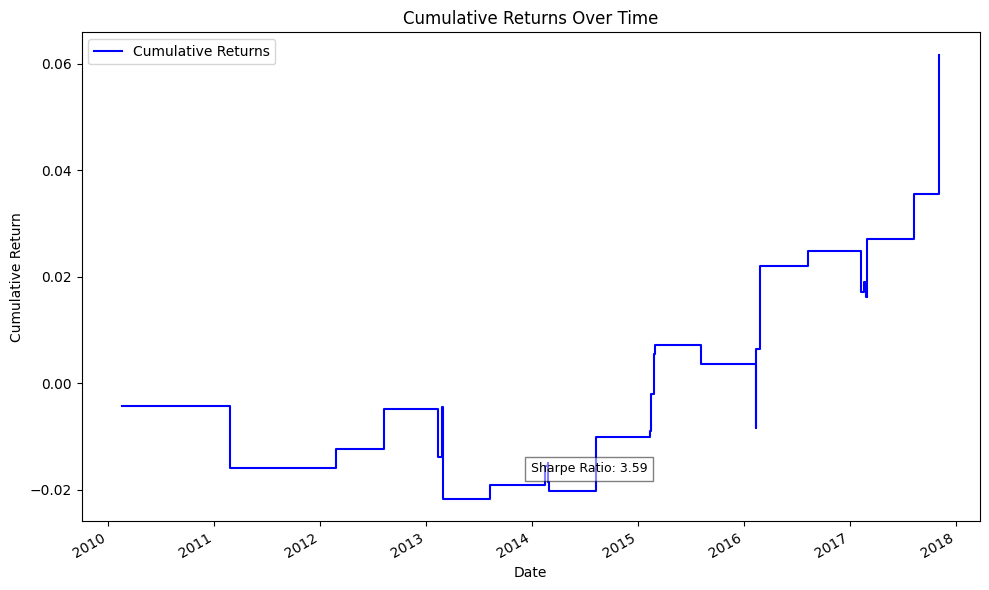

                            OLS Regression Results                            
Dep. Variable:              LS_return   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                 -0.053
Method:                 Least Squares   F-statistic:                    0.5825
Date:                Sun, 16 Mar 2025   Prob (F-statistic):              0.678
Time:                        19:48:09   Log-Likelihood:                 117.61
No. Observations:                  34   AIC:                            -225.2
Df Residuals:                      29   BIC:                            -217.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.615      0.5

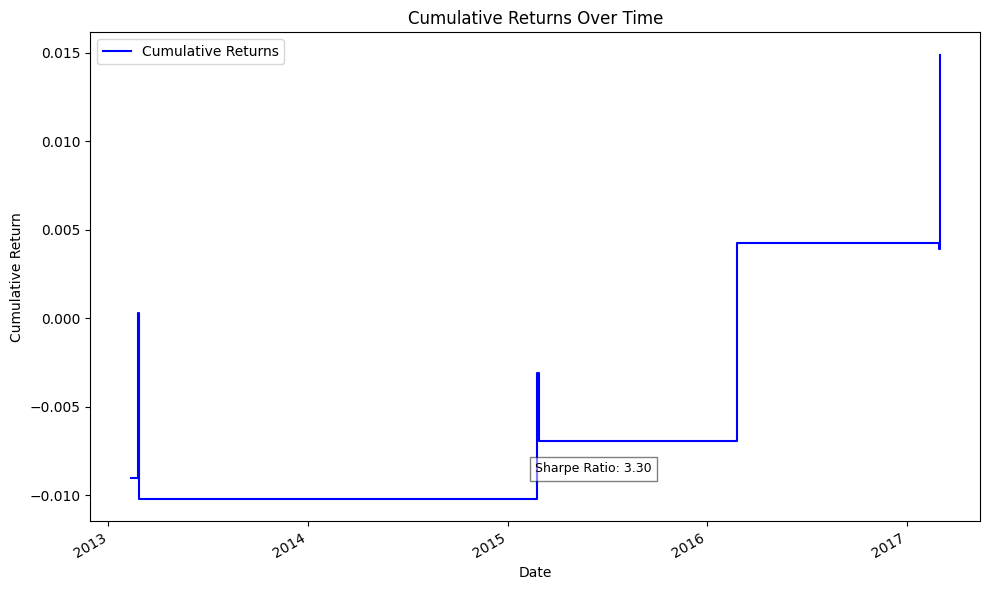

                            OLS Regression Results                            
Dep. Variable:           LS_return_v2   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                 -0.962
Method:                 Least Squares   F-statistic:                    0.1417
Date:                Sun, 16 Mar 2025   Prob (F-statistic):              0.955
Time:                        19:48:09   Log-Likelihood:                 27.591
No. Observations:                   8   AIC:                            -45.18
Df Residuals:                       3   BIC:                            -44.79
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.008     -0.056      0.9

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [66]:
# Merge sentiment data with stock returns
merged_df_dict = merge_sentiment_with_returns(sentiment_dict, df_d)

# Define positions based on sentiment
long_positions_dict, short_positions_dict = define_positions(merged_df_dict)
strategy_dict = calculate_position_returns(long_positions_dict, short_positions_dict)

# Analyze cumulative returns
analyze_cumulative_returns(strategy_dict, column_name='LS_return')

# Strategy with percentiles
long_positions_v2_dict, short_positions_v2_dict = define_positions_by_percentile(merged_df_dict)
strategy_dict_v2 = calculate_position_returns_v2(long_positions_v2_dict, short_positions_v2_dict)

# Analyze cumulative returns for second strategy
analyze_cumulative_returns(strategy_dict_v2, column_name='LS_return_v2')


## 2. GPT-Based Sentiment Strategies
- 2.1 Simple Long-Short
- 2.2 Long top 10 percentile, Short bottom 10 percentile

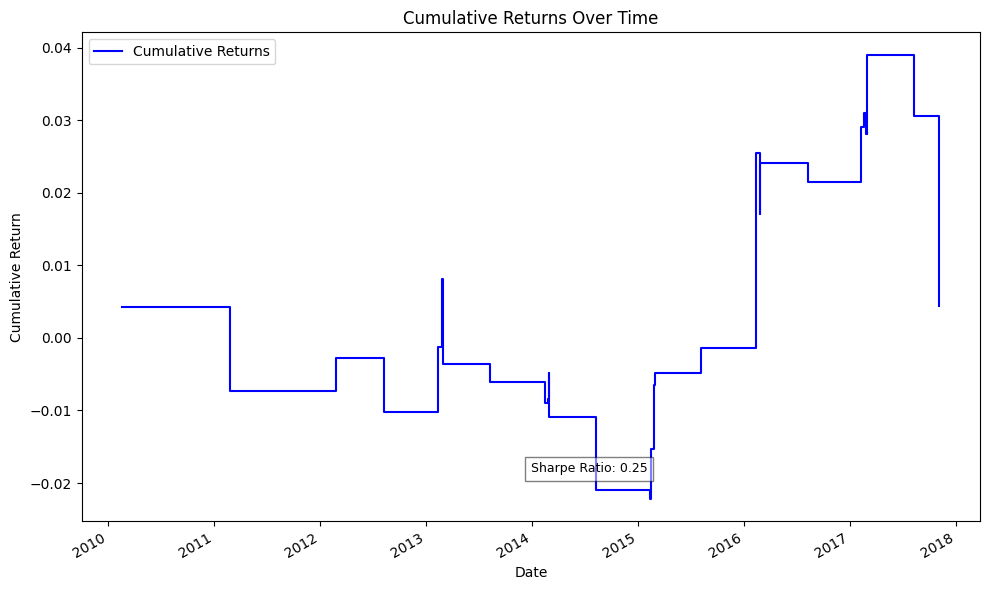

                            OLS Regression Results                            
Dep. Variable:              LS_return   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.975
Date:                Sun, 16 Mar 2025   Prob (F-statistic):              0.124
Time:                        21:08:51   Log-Likelihood:                 123.50
No. Observations:                  35   AIC:                            -237.0
Df Residuals:                      30   BIC:                            -229.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.960      0.3

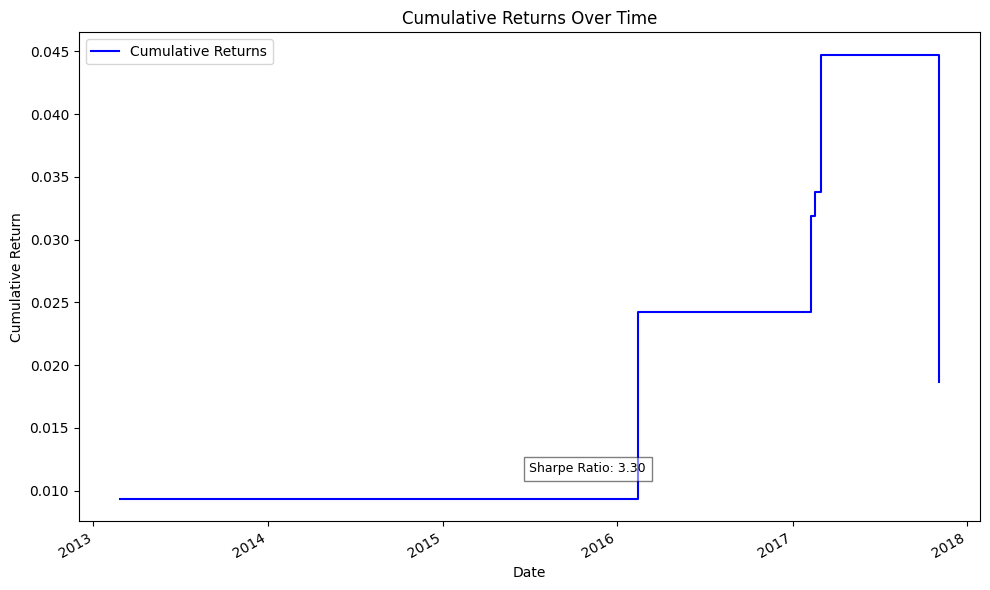

                            OLS Regression Results                            
Dep. Variable:           LS_return_v2   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     4.208
Date:                Sun, 16 Mar 2025   Prob (F-statistic):              0.349
Time:                        21:08:51   Log-Likelihood:                 25.901
No. Observations:                   6   AIC:                            -41.80
Df Residuals:                       1   BIC:                            -42.84
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0119      0.004      2.750      0.2

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [100]:
# Merge GPT sentiment data with stock returns
merged_df_gpt = merge_sentiment_with_returns(sentiment_gpt, df_d)

# Define positions based on sentiment
long_positions_gpt, short_positions_gpt = define_positions(merged_df_gpt)
strategy_gpt = calculate_position_returns(long_positions_gpt, short_positions_gpt)

# Analyze cumulative returns
analyze_cumulative_returns(strategy_gpt, column_name='LS_return')

# Strategy with percentiles
long_positions_v2_gpt, short_positions_v2_gpt = define_positions_by_percentile(merged_df_gpt)
strategy_gpt_v2 = calculate_position_returns_v2(long_positions_v2_gpt, short_positions_v2_gpt)

# Analyze cumulative returns for second strategy
analyze_cumulative_returns(strategy_gpt_v2, column_name='LS_return_v2')



## 3. FinBERT-Based Sentiment Strategies: 
- 3.1 Simple Long-Short
- 3.2 Long top 10 percentile, Short bottom 10 percentile

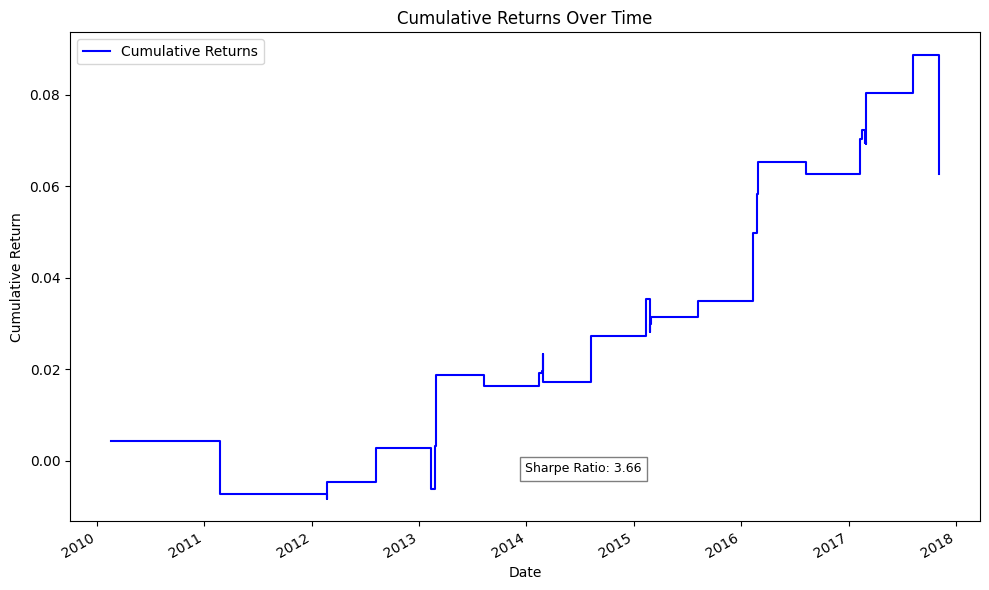

                            OLS Regression Results                            
Dep. Variable:              LS_return   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.8476
Date:                Sun, 16 Mar 2025   Prob (F-statistic):              0.507
Time:                        19:50:07   Log-Likelihood:                 118.39
No. Observations:                  34   AIC:                            -226.8
Df Residuals:                      29   BIC:                            -219.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.720      0.4

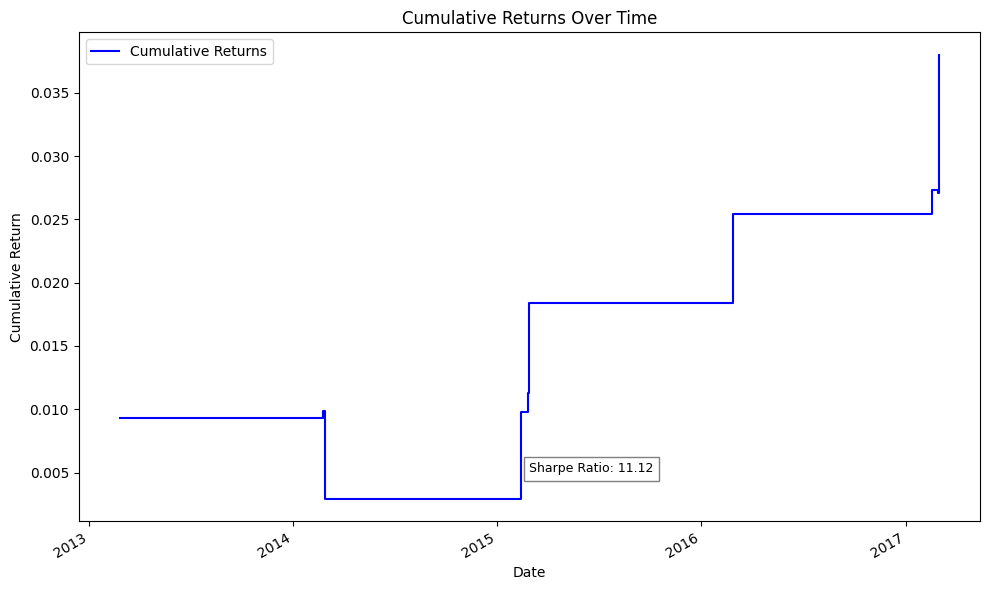

                            OLS Regression Results                            
Dep. Variable:           LS_return_v2   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                 -0.320
Method:                 Least Squares   F-statistic:                    0.4549
Date:                Sun, 16 Mar 2025   Prob (F-statistic):              0.767
Time:                        19:50:07   Log-Likelihood:                 40.051
No. Observations:                  10   AIC:                            -70.10
Df Residuals:                       5   BIC:                            -68.59
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.014      0.1

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [68]:
# Merge FinBERT sentiment data with stock returns
merged_df_finbert = merge_sentiment_with_returns(sentiment_finbert, df_d)

# Define positions based on sentiment
long_positions_finbert, short_positions_finbert = define_positions(merged_df_finbert)
strategy_finbert = calculate_position_returns(long_positions_finbert, short_positions_finbert)

# Analyze cumulative returns
analyze_cumulative_returns(strategy_finbert, column_name='LS_return')

# Strategy with percentiles
long_positions_v2_finbert, short_positions_v2_finbert = define_positions_by_percentile(merged_df_finbert)
strategy_finbert_v2 = calculate_position_returns_v2(long_positions_v2_finbert, short_positions_v2_finbert)

# Analyze cumulative returns for second strategy
analyze_cumulative_returns(strategy_finbert_v2, column_name='LS_return_v2')
